In [1]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = 'drive/My Drive/Colab Notebooks/AMF'

Mounted at /content/drive/


In [ ]:
!pip install optuna
!pip install shap
!pip install scikit-multilearn
!pip install catboost
!pip install liac-arff
!python -m pip install autogluon

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Read the data

In [4]:
file = os.path.join(data_path, "all.csv")

df = pd.read_csv(
    file,
    delimiter="\t",
    converters={
        "longitude": lambda x: pd.to_numeric(x, errors="coerce"),
        "latitude": lambda x: pd.to_numeric(x, errors="coerce"),
        "MAT": lambda x: pd.to_numeric(x, errors="coerce"),
        "MAP": lambda x: pd.to_numeric(x, errors="coerce"),
        "pH": lambda x: pd.to_numeric(x, errors="coerce")
    }
)


# Prepare and analyze the data

In [5]:
X_cols = ['paper_id', 'primers', 'longitude', 'latitude', 'continent',
       'sample_type', 'marker_size', 'Biome', 'MAT', 'MAP', 'pH',
        'plants_dominant', 'target_gene',
       'sequencing_platform']


In [6]:
Y_cols = df.columns[(len(X_cols)+1):]

In [7]:
Y_cols

Index(['Dominikia disticha', 'Rhizophagus prolifer', 'Acaulospora_colossica',
       'Acaulospora_laevis', 'Acaulospora_minuta', 'Cetraspora_nodosa',
       'Acaulospora _lacunosa', 'Rhizophagus fasciculatus',
       'Diversispora gibbosa', 'Diversispora sabulosa', 'Diversispora epigaea',
       'Acaulospora_pustulata', 'Ambispora_leptoticha',
       'Rhizophagus manihotis', 'Archaeospora_trappei', 'Rhizophagus clarus',
       'Rhizophagus microaggregatum', 'Archaeospora_ecuadoriana',
       'Claroideoglomus_drummondii', 'Rhizophagus irregularis',
       'Ambispora_fennica', 'Acaulospora_koskei', 'Acaulospora_cavernata',
       'Gigaspora margarita', 'Diversispora celata', 'Septoglomus nigrum',
       'Cetraspora_gilmorei', 'Septoglomus viscosum', 'Gigaspora decipiens',
       'Dominikia iranica', 'Glomus microcarpum', 'Claroideoglomus_claroideum',
       'Ambispora_callosa', 'Diversispora_arenaria', 'Funneliformis geosporum',
       'Claroideoglomus_candidum', 'Diversispora trimurales

The are duplicate input entries in the data, as a result of joining the data of each species and marker size, so we need to group by samples, i.e., by input variables and take the sum of species abundances. We will then convert it to presence/absence data.

In [8]:
X_cols = ['paper_id', 'longitude', 'latitude', 'continent',
       'sample_type', 'Biome', 'plants_dominant', 'target_gene',
       'sequencing_platform', 'MAP', 'MAT', 'pH']

In [9]:
X_cols_selected = ['paper_id', 'longitude', 'latitude', 'continent',
       'sample_type', 'Biome', 'plants_dominant', 'target_gene',
       'sequencing_platform', 'MAP', 'MAT', 'pH']

df2 = df[X_cols_selected + Y_cols.tolist()]

We need to separate plants in plants_dominant column, as there are observations containing many plants in a single sample. The reason is that we want to use plants as a predictor.

In [10]:
len(df2)

4105

In [11]:
df2.loc[:, "plants_dominant"] = df2["plants_dominant"].str.split(";")

In [12]:
df2["plants_dominant"]

,plants_dominant
0,[Echinops sphaerocephalus]
1,[Echinops sphaerocephalus]
2,[Arrhenatherum elatius]
3,[Daucus carota]
4,[Achillea millefolium]
...,...
4100,[Calamagrostis epigejos]
4101,"[Psidium cattleianum, Schinus terebinthifolius..."
4102,[Festuca brevipila]
4103,[Solanum tuberosum]


In [13]:
df3 = df2.explode("plants_dominant", ignore_index=True)


In [14]:
len(df3)

7040

In [15]:
df3 = df3.groupby(X_cols_selected).mean().reset_index()
df3.shape

(2396, 76)

We need to remove the species without any occurences, this is due to the preprocessing, where the observations with NAs in environmental variables are removed leaving columns with all zeroes. There are only three such species:

In [16]:
Y_cols[df3[Y_cols].sum(axis=0)==0]

Index(['Septoglomus nigrum', 'Cetraspora_gilmorei',
       'Funneliglomus sanmartinense'],
      dtype='object')

We remove these species, and convert abundancies to presence/absence i.e., 1/0:


In [17]:
Y_cols_selected = Y_cols[df3[Y_cols].sum(axis=0)>0]
df3.loc[:,Y_cols_selected] = np.where(df3[Y_cols_selected]>0, 1, df3[Y_cols_selected])
df3 = df3[X_cols_selected+Y_cols_selected.tolist()]
df3.head()

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,...,Diversispora varaderana,Claroideoglomus_lamelossum,Dentiscutata_heterogama,Dominikia minuta,Diversispora peridiata,Acaulospora_alpina,Dominikia indica,Acaulospora_viridis,Funneliformis mosseae,Diversispora eburnea
0,Badi_2019_1AC,32.7611,13.1010,Africa,root,cropland,Sorghum bicolor,SSU,IonTorrent,333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Boeraeve_2019_1AJ,4.9041,50.8658,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boeraeve_2019_1AJ,4.9362,50.8512,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Boeraeve_2019_1AJ,4.9365,50.8512,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Boeraeve_2019_1AJ,4.9366,50.8498,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us have a look at the resulting dataset:

In [18]:
len(df3)

2396

The characteristic of this dataset is that it combines many different studies, in some cases many plants are gathered as an ensemble in one observation, in other studies many different plants associated with one location is separated into separate lines. For prediction purposes, to use plant variable as a predictor, we will have to separate plants associated with one single location into separate lines.

There are also different sample types associated with a single location. Let us now look how many different sample types are there:

In [19]:
df3.groupby(["sample_type"])["plants_dominant"].agg([("count", "count")]).sort_values("count", ascending=False)

,count
sample_type,
soil,1267
root,974
rhizosphere soil,114
topsoil,32
sediment,9


Now, let us see group by locations and see how many different samples are taken from a single location:

In [21]:
repeated_samples = df3.groupby(["longitude", "latitude", "sample_type"]).size().sort_values(ascending=False)
repeated_samples.name = "count"
repeated_samples.head(10)

,,,count
longitude,latitude,sample_type,
14.4892,52.4630,soil,37
-73.9400,45.4300,root,37
-73.3700,45.7200,rhizosphere soil,33
112.2900,35.2000,soil,24
-113.9840,46.6900,root,22
16.9740,48.2010,root,21
-113.8760,49.0857,root,21
-113.8500,49.1287,root,19
-113.9890,46.6780,root,18


Around 7% of observations have the same location (longitude, latitude) and the same sample type:

In [22]:
np.round(len(repeated_samples[repeated_samples>1])*100/len(df2),2)

7.26

The question is what variables are different for these locations? Let us look at the first location in the table above:

### First observation

In [ ]:
obs1 = df3.loc[(df3["longitude"] == -73.9400) & (df3["latitude"] == 45.4300), ]
obs1[X_cols_selected].head(15)

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
389,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,4.89
390,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.19
391,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.20
392,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.27
393,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.44
394,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.47
395,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.65
396,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.68
397,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.76
398,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.84


We see that there are two plants occuring repeatedly. The pH values are different for each location. We need perhaps look at the paper of this study: Tonia de Bellis et al., 2019. "Shared mycorrhizae but distinct communities of other root-associated microbes on co-occurring native and invasive maples.". They took samples from 5 parallel transects on 8 different dates: only latitudinal and longitudinal coordinate of a reserved forest is given. The sequencing and metadata species data were analyzed by Vetrovsky et al., 2023, where  "The resulting SSU sequences were classified according to the closest match among representative sequences of MaarjAM VT".

Now let us how much pH levels vary. We see that it varies from 4.89 to 6.47:

In [ ]:
obs1["pH"].describe()

,pH
count,37.000000
mean,5.754324
std,0.389612
min,4.890000
25%,5.440000
50%,5.770000
75%,6.070000
max,6.470000


There is only one species classified for this study as per analysis by Vetrovsky, 2023.

In [ ]:
Y_cols_selected[(obs1[Y_cols_selected].sum(axis=0)>0).tolist()][0]

'Diversispora epigaea'

### Second observation

In the study below , there is one plant, but again different pH values:

In [ ]:
obs2 = df3.loc[(df3["longitude"] == 14.4892) & (df3["latitude"] == 52.4630), ]
obs2[X_cols_selected].head(10)



,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
693,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.58
694,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.70
695,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.84
696,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.12
697,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.34
698,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.39
699,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.43
700,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.78
701,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.83
702,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.93


pH varies from 5.58 to 8.32:

In [ ]:
obs2["pH"].describe()

,pH
count,37.000000
mean,7.258919
std,0.703182
min,5.580000
25%,6.930000
50%,7.430000
75%,7.760000
max,8.320000


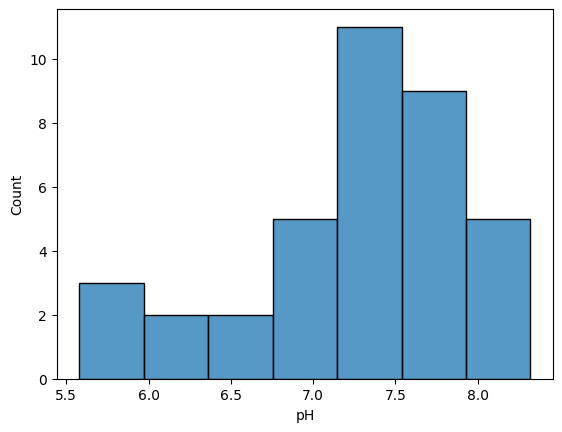

In [ ]:
sns.histplot(obs2["pH"])
plt.show()

In [ ]:
Y_cols_selected[(obs2[Y_cols_selected].sum(axis=0)>0).tolist()]

Index(['Rhizophagus irregularis', 'Septoglomus viscosum',
       'Claroideoglomus_claroideum', 'Claroideoglomus_candidum',
       'Ambispora_gerdemannii', 'Glomus macrocarpum',
       'Septoglomus constrictum', 'Diversispora insculpta', 'Dominikia minuta',
       'Dominikia indica'],
      dtype='object')

### Third observation

The objective of this paper: "The study explores how arbuscular mycorrhizal fungi (AMF) communities are structured in the rhizosphere of willow plants (Salix spp.) grown in hydrocarbon-contaminated versus uncontaminated soils. "With the finding: "Hydrocarbon contamination strongly affects AMF community composition.
Highly contaminated soils are dominated by a small group of AMF taxa, primarily in the genus Rhizophagus, while uncontaminated and moderately contaminated soils have more diverse AMF communities."

The site is divided into two areas:
Uncontaminated area: Blocks N1, N3, and N5.
Contaminated area: Blocks C3, C4, and C5.
These are further classified into:
Low contamination (LC): Block C3.
High contamination (HC): Blocks C4 and C5.
Each block contains 25 m² plots where soil and rhizosphere samples were collected from planted willows or unplanted control areas.



In [ ]:
obs3 = df3.loc[(df3["longitude"] == -73.3700) & (df3["latitude"] == 45.7200), ]
obs3[X_cols_selected].head(10)


,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
649,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,5.4
650,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,5.6
651,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,6.7
652,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,5.4
653,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,5.6
654,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,6.5
655,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,6.7
656,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix caprea,SSU,454Roche,1020,7.2,5.4
657,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix caprea,SSU,454Roche,1020,7.2,5.6
658,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix caprea,SSU,454Roche,1020,7.2,6.5


In [ ]:
obs3["pH"].describe()

,pH
count,33.000000
mean,6.157576
std,0.677325
min,5.400000
25%,5.600000
50%,6.500000
75%,6.700000
max,7.400000


In [ ]:
Y_cols_selected[(obs3[Y_cols_selected].sum(axis=0)>0).tolist()][0]

'Diversispora epigaea'

###Fourth observation

In [ ]:
obs4 = df3.loc[(df3["longitude"] == 112.2900) & (df3["latitude"] == 35.200), ]
obs4[X_cols_selected].head(10)

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
2354,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Brassica campestris,SSU,Illumina,752,10.2,7.27
2355,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Brassica campestris,SSU,Illumina,752,10.2,7.33
2356,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Brassica campestris,SSU,Illumina,752,10.2,7.45
2357,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Ipomoea batatas,SSU,Illumina,752,10.2,7.27
2358,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Ipomoea batatas,SSU,Illumina,752,10.2,7.33
2359,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Ipomoea batatas,SSU,Illumina,752,10.2,7.45
2360,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Lycopersicon esculentum,SSU,Illumina,752,10.2,7.27
2361,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Lycopersicon esculentum,SSU,Illumina,752,10.2,7.33
2362,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Lycopersicon esculentum,SSU,Illumina,752,10.2,7.45
2363,Zhao_2017_1DW,112.29,35.2,Asia,soil,cropland,Triticum aestivum,SSU,Illumina,752,10.2,7.27


### Which study has the largest number of observations?

In [ ]:
group_paper = df3.groupby("paper_id").size().sort_values(ascending=False)
group_paper.name = "size"
group_paper.head(10)

,size
paper_id,
Xiang_2014_BD5B,488
Davison_2015_1GM,138
Rezacova_2021_1HU,135
Morgan_2017_1CJ,120
Fan_2020_1GN,90
Wall_2020_1HX,89
Stover_2018_1DI,88
Lekberg_2013_37D2,84
Rasmussen_2018_C8E6,59


The largest number of observations corresponds to Xiang_2014_BD5B: 488 observations in total. Let us take a look at these observations:

In [ ]:
Xiang_2014_BD5B = df3[df3["paper_id"] == "Xiang_2014_BD5B"]
Xiang_2014_BD5B.head()

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,...,Diversispora varaderana,Claroideoglomus_lamelossum,Dentiscutata_heterogama,Dominikia minuta,Diversispora peridiata,Acaulospora_alpina,Dominikia indica,Acaulospora_viridis,Funneliformis mosseae,Diversispora eburnea
1815,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,cropland,Zea mays,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1816,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Artemisia capillaris,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1817,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Artemisia frigida,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1818,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Carex humilis,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1819,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Carex onoei,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This study concerns Asia. With how many unique locations did this study deal?


In [ ]:
Xiang_2014_BD5B["continent"].value_counts()

,count
continent,
Asia,488


In [ ]:
group_Xiang_2014_BD5B_by_coords = Xiang_2014_BD5B.groupby(["longitude", "latitude"]).size().sort_values(ascending=False)
group_Xiang_2014_BD5B_by_coords.name="count"
group_Xiang_2014_BD5B_by_coords.head()

,,count
longitude,latitude,
102.071,36.4503,14
115.822,40.8524,14
102.310,35.9628,14
111.922,40.7757,14
112.058,39.0587,14


How many different plants?

In [ ]:
Xiang_2014_BD5B_plants = Xiang_2014_BD5B["plants_dominant"].value_counts()
print(f"There are {Xiang_2014_BD5B_plants.shape[0]} number of different plants:")
print(Xiang_2014_BD5B_plants)

There are 14 number of different plants:
plants_dominant
Zea mays                  46
Artemisia capillaris      34
Artemisia frigida         34
Carex humilis             34
Carex onoei               34
Cenchrus incertus         34
Chloris virgata           34
Cleistogenes squarrosa    34
Heteropappus altaicus     34
Lespedeza davurica        34
Leymus chinensis          34
Setaria viridis           34
Stipa caucasica           34
Tribulus terrestris       34
Name: count, dtype: int64


How many different species for each plant?


In [ ]:
species_sums = Xiang_2014_BD5B[Y_cols_selected].sum(axis=0)

species_present = species_sums[species_sums > 0]

species_present.name = "count"

print(len(species_present))
print(species_present.sort_values(ascending=False))


12
Rhizophagus intraradices       351.0
Septoglomus viscosum           217.0
Funneliformis mosseae           55.0
Diversispora trimurales         45.0
Ambispora_fennica               43.0
Diversispora epigaea            33.0
Funneliformis coronatus         33.0
Rhizophagus microaggregatum     31.0
Gigaspora decipiens             15.0
Funneliformis caledonius         3.0
Rhizophagus prolifer             1.0
Archaeospora_trappei             1.0
Name: count, dtype: float64


In [ ]:
Xiang_2014_BD5B[["plants_dominant"] + (species_present.index).tolist()].head(5)

,plants_dominant,Rhizophagus prolifer,Diversispora epigaea,Archaeospora_trappei,Rhizophagus microaggregatum,Ambispora_fennica,Septoglomus viscosum,Gigaspora decipiens,Diversispora trimurales,Funneliformis coronatus,Funneliformis caledonius,Rhizophagus intraradices,Funneliformis mosseae
1815,Zea mays,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1816,Artemisia capillaris,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1817,Artemisia frigida,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1818,Carex humilis,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1819,Carex onoei,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let us have a look at plant - species association, as well as other variables:

In [ ]:
selected_columns = Xiang_2014_BD5B[species_present.index]
Xiang_2014_BD5B.loc[:, 'species_list'] = selected_columns.apply(lambda row: list(row.index[row != 0]), axis=1)


In [ ]:
result = Xiang_2014_BD5B[['plants_dominant', 'longitude', 'latitude','pH','species_list']].sort_values(by=["plants_dominant", "pH"])
result[result['plants_dominant'].str.contains("Zea")].head(10)

,plants_dominant,longitude,latitude,pH,species_list
2160,Zea mays,117.429,40.8484,4.93,[Gigaspora decipiens]
2274,Zea mays,120.894,46.7175,5.85,"[Diversispora trimurales, Rhizophagus intrarad..."
2288,Zea mays,121.305,46.5728,6.35,"[Gigaspora decipiens, Funneliformis mosseae]"
2161,Zea mays,117.509,42.2967,6.43,"[Diversispora epigaea, Rhizophagus intraradices]"
2216,Zea mays,118.244,40.9322,7.09,[Septoglomus viscosum]
2090,Zea mays,114.326,41.0846,7.30,"[Diversispora epigaea, Ambispora_fennica, Sept..."
1815,Zea mays,102.071,36.4503,7.55,"[Diversispora epigaea, Archaeospora_trappei, D..."
1957,Zea mays,107.372,35.3162,7.71,[Septoglomus viscosum]
2231,Zea mays,119.515,43.8600,7.72,"[Septoglomus viscosum, Diversispora trimurales..."
2230,Zea mays,119.188,41.1428,7.74,[Rhizophagus microaggregatum]


# Plant based analysis

Triticum aestivum, i.e., common wheat is the most studied plant with 120 observations.

In [21]:
df3["plants_dominant"].value_counts()

,count
plants_dominant,
Triticum aestivum,120
Zea mays,81
Plantago lanceolata,65
Eragostis tef,52
Theobroma cacao,47
...,...
Thalictrum foetidum,1
Ranunculus pedatifidus,1
Poa attenuata,1


In [ ]:
wheat = df3.loc[df3["plants_dominant"].str.contains("Triticum aestivum")]

In [ ]:
wheat_species_sum = wheat[Y_cols_selected].sum(axis=0)

wheat_species_present = wheat_species_sum[wheat_species_sum > 0]

wheat_species_present.name = "count"

print(f"There are {len(wheat_species_present)} species:")
print(wheat_species_present.sort_values(ascending=False))


There are 16 species:
Funneliformis caledonius      120.0
Rhizophagus intraradices       92.0
Rhizophagus manihotis          90.0
Septoglomus viscosum           85.0
Archaeospora_trappei           81.0
Funneliformis mosseae          62.0
Gigaspora decipiens            41.0
Rhizophagus clarus             17.0
Ambispora_gerdemannii          14.0
Rhizophagus irregularis         6.0
Claroideoglomus_claroideum      6.0
Glomus macrocarpum              3.0
Cetraspora_nodosa               2.0
Diversispora epigaea            2.0
Diversispora trimurales         2.0
Claroideoglomus_candidum        1.0
Name: count, dtype: float64


How many continents for wheat?

In [ ]:
wheat["continent"].value_counts()

,count
continent,
Asia,95
Europe,28
North America,2


In [ ]:
wheat_species_list = wheat[wheat_species_present.index].apply(lambda row:list(row.index[row!=0]), axis=1)
wheat_species_list.name = "species_list"
wheat_species_list.head()

,species_list
52,"[Diversispora epigaea, Archaeospora_trappei, F..."
56,"[Diversispora epigaea, Funneliformis caledoniu..."
495,"[Rhizophagus manihotis, Archaeospora_trappei, ..."
496,"[Rhizophagus manihotis, Archaeospora_trappei, ..."
497,"[Rhizophagus manihotis, Rhizophagus clarus, Se..."


Let us test ecopy.

Graph visualization of species co-occurence:

In [ ]:
import networkx as nx

In [ ]:
wheat_species = wheat[wheat_species_present.index]
wheat_species.values

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [ ]:
co_occurrence_matrix = np.dot(wheat_species.to_numpy().T, wheat_species.to_numpy())

co_occurrence_matrix

In [ ]:
triu_indices = np.triu_indices_from(co_occurrence_matrix, k=1)
co_occurrence_values = co_occurrence_matrix[triu_indices]
co_occurrence_values

In [ ]:
triu_indices

In [ ]:
top_5_indices = np.argsort(co_occurrence_values)[-5:][::-1]
[(triu_indices[0][i], triu_indices[1][i], co_occurrence_values[i]) for i in top_5_indices]


[(13, 14, 92.0), (2, 13, 88.0), (2, 14, 88.0), (6, 13, 85.0), (6, 14, 84.0)]

In [ ]:
wheat_species_present.index[13]


'Funneliformis caledonius'

In [ ]:
wheat_species_present.index[list({triu_indices[0][i] for i in top_5_indices})]


Index(['Rhizophagus manihotis', 'Funneliformis caledonius',
       'Septoglomus viscosum'],
      dtype='object')

In [ ]:
# Find the indices of the top 5 most frequent co-occurrences
top_5_indices = np.argsort(co_occurrence_values)[-5:][::-1]

# Extract the species pairs and their co-occurrence counts
top_5_pairs = [(triu_indices[0][i], triu_indices[1][i], co_occurrence_values[i]) for i in top_5_indices]

# Print the results
print("Top 5 most co-occurring species pairs:")
for species_1, species_2, count in top_5_pairs:
    print(f"Species {species_1} and Species {species_2} co-occurred {count} times")

In [ ]:
G = nx.Graph()
for i, species_1 in enumerate(wheat_species.columns):
    for j, species_2 in enumerate(wheat_species.columns):
        if i != j and co_occurrence_matrix[i, j] > 0:
            G.add_edge(species_1, species_2, weight=co_occurrence_matrix[i, j])


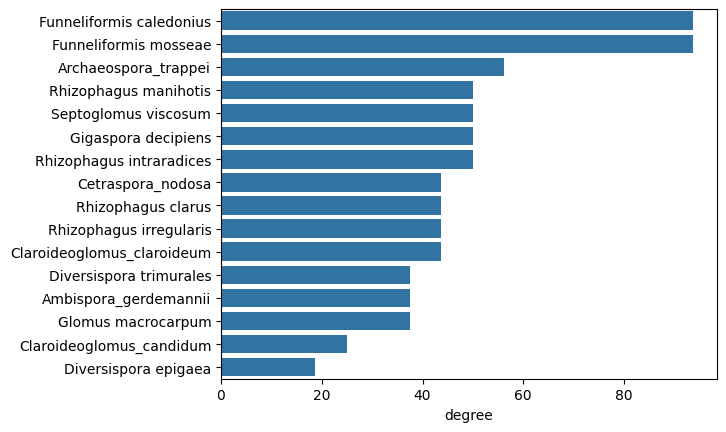

In [ ]:
degrees = pd.Series(dict(G.degree()))
degrees.name = "degree"
degrees = degrees*100/len(wheat_species_present)
degrees.sort_values(ascending=False)
sns.barplot(degrees.sort_values(ascending=False), orient="h")
plt.show()

In [ ]:
degrees/len(wheat_species_present)


,degree
Cetraspora_nodosa,0.4375
Rhizophagus manihotis,0.5000
Archaeospora_trappei,0.5625
Septoglomus viscosum,0.5000
Gigaspora decipiens,0.5000
Funneliformis caledonius,0.9375
Rhizophagus intraradices,0.5000
Funneliformis mosseae,0.9375
Diversispora epigaea,0.1875
Rhizophagus clarus,0.4375


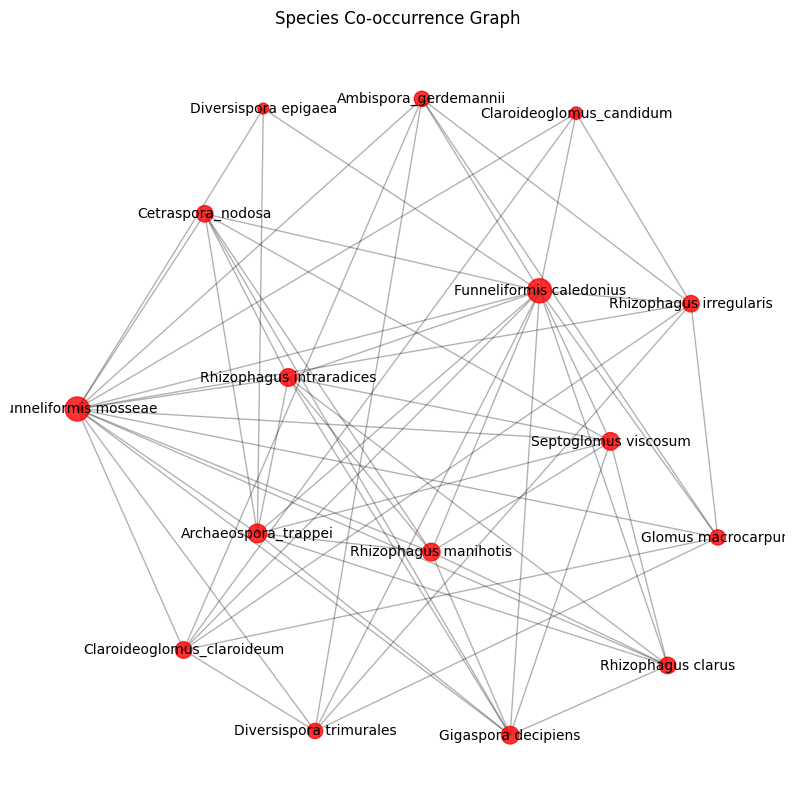

In [ ]:
degrees = dict(G.degree())
node_sizes = [v*20 for v in degrees.values()]  # Scale factor for visualization

# Draw graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=10)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='red', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title("Species Co-occurrence Graph")
plt.axis("off")
plt.show()


Denstiy plot for pH:

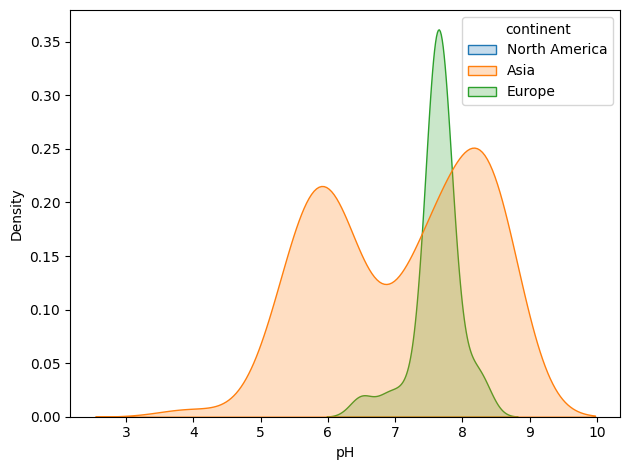

In [ ]:
sns.kdeplot(data=wheat, x='pH', hue='continent', fill=True, warn_singular=False)
plt.tight_layout()

North America is visible in the following frequency plot:

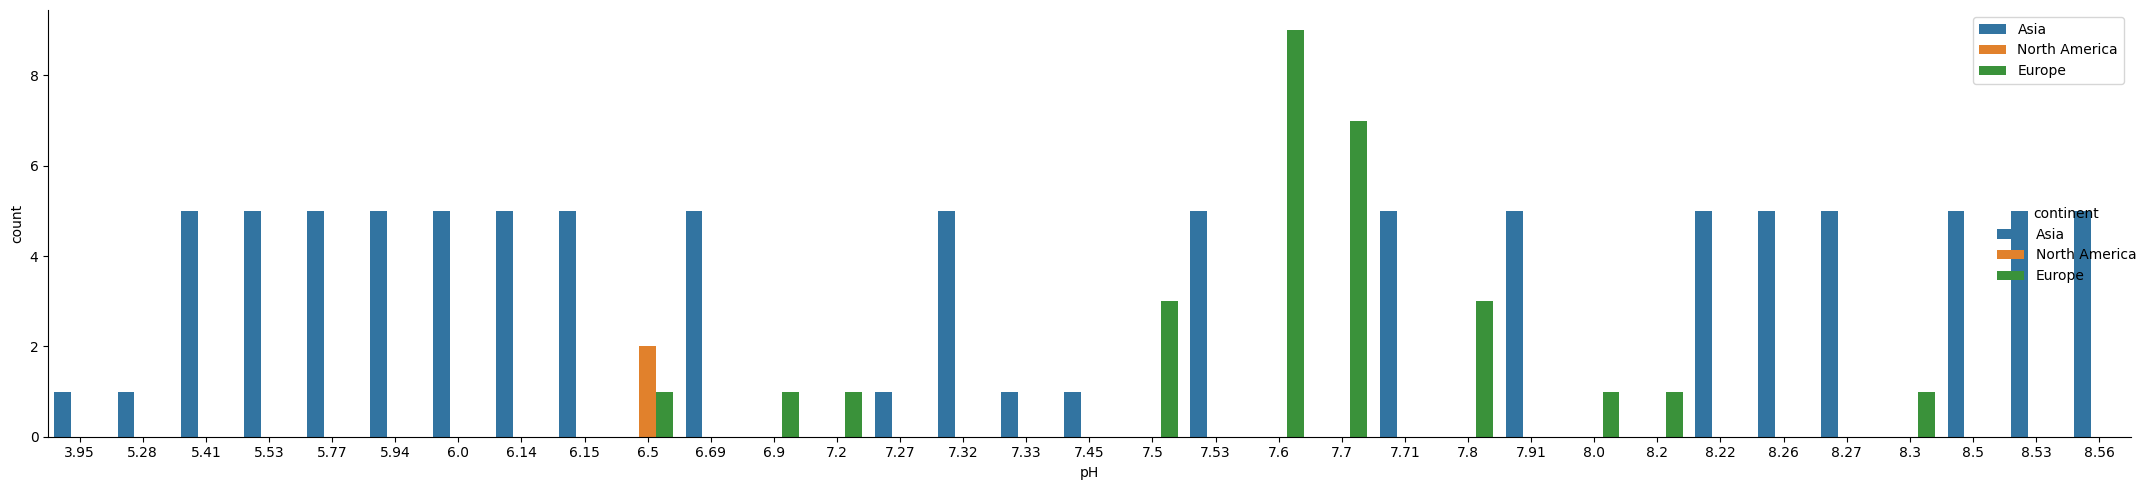

In [ ]:
sns.catplot(data=wheat, x='pH', kind='count', hue='continent', aspect=4.0)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

### Rare species

In [31]:
df3[Y_cols_selected].sum(axis=0).sort_values(ascending=True).head(30)


,0
Desertispora_omaniana,1.0
Acaulospora_viridis,1.0
Ambispora_granatensis,2.0
Acaulospora_pustulata,2.0
Dominikia iranica,2.0
Acaulospora_colossica,3.0
Acaulospora_alpina,3.0
Septoglomus mediterraneum,3.0
Dentiscutata_erythropus,4.0
Gigaspora rosea,4.0


# **Prediction**

### Select input variables and species

We will choose a subset of most frequent species. Let us first compute the relative frequencies of species:

In [23]:
rel_freq = df3[Y_cols_selected].sum(axis=0)*100/len(df3)
rel_freq.name = "RF"
rel_freq = rel_freq.sort_values(ascending=False)
rel_freq.head(30)

,RF
Rhizophagus intraradices,44.156928
Septoglomus viscosum,23.539232
Funneliformis mosseae,19.824708
Diversispora epigaea,14.649416
Funneliformis caledonius,13.188648
Gigaspora decipiens,13.063439
Rhizophagus irregularis,11.936561
Rhizophagus manihotis,11.727880
Archaeospora_trappei,11.310518
Diversispora trimurales,9.474124


We select top 5 most frequent species and train XGBoost model for each and see the feature importance for each and whether there is some overlap.

In [24]:
top_species = rel_freq.head(10).index.tolist()
#top_species

In [25]:
cols_exclude = ["paper_id", "primers", "marker_size", "continent", "sequencing_platform", "sample_type", "target_gene", "plants_dominant"]
X_cols_selected = [col for col in X_cols if col not in cols_exclude]
X_cols_selected

['longitude', 'latitude', 'Biome', 'MAP', 'MAT', 'pH']

Once we remove the plant variable, there will be duplicate observations, whose species content might be different. That's why we need to do aggregation:

In [26]:
df4 = df3.groupby(X_cols_selected)[top_species].sum()
df4.reset_index(inplace=True)

In [27]:
X = df4[X_cols_selected]
df4[df4[top_species] >0] =1
Y = df4[top_species]


In [28]:
for col in X.columns:
     if X[col].dtype=="object": X[col] = X[col].astype("category")

X.dtypes

<ipython-input-28-ab664ac924d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if X[col].dtype=="object": X[col] = X[col].astype("category")


,0
longitude,float64
latitude,float64
Biome,category
MAP,int64
MAT,float64
pH,float64


### Stratified sampling

In [29]:
import skmultilearn.dataset
#from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

In [30]:
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[0.2, 0.8])

train_indexes, test_indexes = next(stratifier.split(X.to_numpy(), Y))

X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], Y.iloc[train_indexes], Y.iloc[test_indexes]

#X_train, y_train, X_test, y_test = iterative_train_test_split(X.to_numpy(), Y.to_numpy(), test_size = 0.2)

In [31]:
pd.DataFrame({"train":y_train.sum(axis=0), "test":y_test.sum(axis=0)})

,train,test
Rhizophagus intraradices,343.0,86.0
Septoglomus viscosum,218.0,54.0
Funneliformis mosseae,204.0,51.0
Diversispora epigaea,196.0,49.0
Funneliformis caledonius,201.0,50.0
Gigaspora decipiens,173.0,43.0
Rhizophagus irregularis,118.0,30.0
Rhizophagus manihotis,184.0,46.0
Archaeospora_trappei,156.0,39.0
Diversispora trimurales,132.0,33.0


## XGBoost

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

def objective_fungi(trial):

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "hist", ### do not forget to change it from exact to hist if you use categorical variables
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.train(param, dtrain)
    preds = model.predict(dvalid)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels, average="macro")  # Calculate F1 score
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective_fungi, n_trials=100, timeout=600)


In [67]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  11
Best trial:
  Value: 0.8248981966259453
  Params: 
    iterations: 900
    learning_rate: 0.12049120518407322
    depth: 7
    l2_leaf_reg: 0.003104605242196618
    random_strength: 0.026636488649502407
    bagging_temperature: 0.7672162319453505
    border_count: 187


In [ ]:
model = xgb.XGBClassifier(**best_trial.params, enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(alpha=0.005515634483993785, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9085067205970231, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.6464217803248168, eval_metric=None, feature_types=None,
              gamma=5.970812417022083e-05, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=2.4457420776627734e-07, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [208]:
preds = model.predict(X_test)
k = 10
preds = preds[:, :k]

macro_f1 = f1_score(y_test.values[:, :k], preds, average="macro")
micro_f1 = f1_score(y_test.values[:, :k], preds, average="micro")
hl = hamming_loss(y_test.values[:, :k], preds)
acc = accuracy_score(y_test.values[:, :k], preds)

print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


NameError: name 'model' is not defined

## CatBoost

In [90]:
X_train.dtypes

,0
longitude,float64
latitude,float64
Biome,category
MAP,int64
MAT,float64
pH,float64


In [93]:
# Objective function for Optuna
def objective_catboost_chain(trial):
    # Define CatBoost parameters
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
          }

    model = CatBoostClassifier(
        **param,
        verbose=0,
        cat_features=[2],
        loss_function='MultiLogloss'
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average="micro")
    #acc = accuracy_score(y_test, y_pred)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost_chain, n_trials=100, timeout=600)


In [210]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  9
Best trial:
  Value: 0.7664155005382132
  Params: 
    iterations: 100
    learning_rate: 0.24405410560364554
    depth: 5
    l2_leaf_reg: 0.001702115225731454
    random_strength: 1.682569456294934
    bagging_temperature: 0.8569643996395129
    border_count: 78


In [211]:
catmodel = CatBoostClassifier(
        **best_trial.params,
        verbose=0,
        cat_features=[2],
        loss_function='MultiLogloss'
        )
catmodel.fit(X_train, y_train)

In [212]:
preds = catmodel.predict(X_test)

In [61]:
preds_proba = catmodel.predict_proba(X_test)

In [80]:
thresholds = [x/100.0 for x in range(1, 90, 1)]

def lco(preds, Y_train):
    t = which_threshold(preds, Y_train)
    A = np.where(preds >= t, 1, 0)
    A = correct_all_zero_rows(A, preds)
    return A

def which_threshold(preds, Y_train):
    lcard = np.sum(Y_train) / Y_train.shape[0]
    nrow = preds.shape[0]
    preds_lcard = [np.sum(preds >= thresholds[i])/nrow for i in range(len(thresholds))]
    ind =  np.argmin(abs(lcard - preds_lcard))
    return thresholds[ind]


def correct_all_zero_rows(A, preds):
    zero_rows = np.all(A == 0, axis=1)
    if np.sum(zero_rows):
        max_indices = np.argmax(preds[zero_rows], axis=1)
        A[zero_rows, max_indices] = 1
    return A



In [98]:
preds_lco = lco(preds_proba, y_train.to_numpy())

In [216]:
k=10
preds2 = preds[:, :k]
y_testv = y_test[:, :k]


#f1 = f1_score(y_testv, preds2, average="binary")
macro_f1 = f1_score(y_testv, preds2, average="macro")
micro_f1 = f1_score(y_testv, preds2, average="micro")
hl = hamming_loss(y_testv, preds2)
acc = accuracy_score(y_testv, preds2)


print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


Macro F1 Score: 0.761
Micro F1 Score: 0.766
Hamming loss: 0.083
Accuracy score: 0.483


In [214]:
for k in range(10):
  preds2 = preds[:, k]
  y_testv = y_test[:, k]


  f1 = f1_score(y_testv, preds2, average="binary")
  macro_f1 = f1_score(y_testv, preds2, average="macro")
  micro_f1 = f1_score(y_testv, preds2, average="micro")
  hl = hamming_loss(y_testv, preds2)
  acc = accuracy_score(y_testv, preds2)

  print(f"F1 Score: {f1:.3f}")

  #print(f"Macro F1 Score: {macro_f1:.3f}")
  #print(f"Micro F1 Score: {micro_f1:.3f}")
  #print(f"Hamming loss: {hl:.3f}")
  #print(f"Accuracy score: {acc:.3f}")


F1 Score: 0.831
F1 Score: 0.636
F1 Score: 0.653
F1 Score: 0.706
F1 Score: 0.762
F1 Score: 0.795
F1 Score: 0.772
F1 Score: 0.935
F1 Score: 0.747
F1 Score: 0.776


It seems that CatBoost model performs better than XGBoost. Let us now take some random 5 locations and see what the algorithm predicts.

In [ ]:
random_indices = np.random.choice(X_test.shape[0], size=5, replace=False)
random_indices

NameError: name 'np' is not defined

First random example:

In [ ]:
l = random_indices[0]

df3.loc[l, X_cols]

,314
paper_id,Davison_2015_1GM
longitude,142.15
latitude,-37.3333
continent,Australia
sample_type,root
Biome,grassland
plants_dominant,Themeda triandra
target_gene,SSU
sequencing_platform,454Roche
MAP,643


Prediction:

In [ ]:
pd.DataFrame({"true":y_test.iloc[l], "preds": catmodel.predict(X_test.iloc[l])})

,true,preds
Rhizophagus intraradices,0.0,0
Septoglomus viscosum,0.0,0
Funneliformis mosseae,0.0,0
Diversispora epigaea,0.0,0
Funneliformis caledonius,0.0,0
Gigaspora decipiens,0.0,0
Rhizophagus irregularis,0.0,0
Rhizophagus manihotis,0.0,0
Archaeospora_trappei,0.0,0
Diversispora trimurales,0.0,0


Second example:

In [ ]:
l = random_indices[1]
df3.loc[l, X_cols]

,434
paper_id,Ezeokoli_2020_1AW
longitude,29.1861
latitude,-25.9954
continent,Africa
sample_type,root
Biome,grassland
plants_dominant,Eragostis tef
target_gene,SSU
sequencing_platform,Illumina
MAP,778


In [ ]:
pd.DataFrame({"true":y_test.iloc[l], "preds": catmodel.predict(X_test.iloc[l])})

,true,preds
Rhizophagus intraradices,0.0,0
Septoglomus viscosum,1.0,0
Funneliformis mosseae,0.0,0
Diversispora epigaea,0.0,0
Funneliformis caledonius,0.0,0
Gigaspora decipiens,1.0,1
Rhizophagus irregularis,0.0,0
Rhizophagus manihotis,0.0,0
Archaeospora_trappei,0.0,0
Diversispora trimurales,0.0,0


Third example:

In [ ]:
l = random_indices[2]
df3.loc[l, X_cols]

,212
paper_id,Davison_2015_1GM
longitude,-71.4225
latitude,-52.055
continent,South America
sample_type,root
Biome,grassland
plants_dominant,Taraxacum officinale
target_gene,SSU
sequencing_platform,454Roche
MAP,344


In [ ]:
pd.DataFrame({"true":y_test.iloc[l], "preds": catmodel.predict(X_test.iloc[l])})

,true,preds
Rhizophagus intraradices,1.0,1
Septoglomus viscosum,0.0,1
Funneliformis mosseae,0.0,0
Diversispora epigaea,0.0,0
Funneliformis caledonius,1.0,1
Gigaspora decipiens,0.0,1
Rhizophagus irregularis,0.0,0
Rhizophagus manihotis,1.0,1
Archaeospora_trappei,1.0,1
Diversispora trimurales,0.0,0


Fourth location:

In [ ]:
l = random_indices[3]
df3.loc[l, X_cols]

,406
paper_id,DeBellis_2019_EH
longitude,-73.94
latitude,45.43
continent,North America
sample_type,root
Biome,forest
plants_dominant,Acer platanoides
target_gene,SSU
sequencing_platform,Illumina
MAP,1025


In [ ]:
catmodel.predict_proba(X_test.iloc[l])

array([2.86701774e-01, 2.98025945e-03, 3.24417056e-03, 2.87845955e-03,
       3.25786808e-04, 2.57284183e-03, 1.00026483e-03, 1.23744627e-04,
       4.12376896e-04, 2.20731852e-01])

In [ ]:
pd.DataFrame({"true":y_test.iloc[l], "preds": catmodel.predict(X_test.iloc[l])})

,true,preds
Rhizophagus intraradices,0.0,0
Septoglomus viscosum,1.0,0
Funneliformis mosseae,0.0,0
Diversispora epigaea,0.0,0
Funneliformis caledonius,0.0,0
Gigaspora decipiens,0.0,0
Rhizophagus irregularis,0.0,0
Rhizophagus manihotis,0.0,0
Archaeospora_trappei,0.0,0
Diversispora trimurales,0.0,0


## Autogluon


In [32]:
X_train = X_train.join(pd.get_dummies(X_train["Biome"], dtype="int")).drop(columns=["Biome"])
X_test = X_test.join(pd.get_dummies(X_test["Biome"], dtype="int")).drop(columns=["Biome"])

In [33]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [40]:
labels =  top_species
problem_types = ['binary'] * len(labels)
eval_metrics = ['f1'] * len(labels)

multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics, path=data_path)


In [ ]:
multi_predictor.fit(train_data, presets='best_quality')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.27 GB / 12.67 GB (81.0%)
Disk Space Avail:   5.04 GB / 15.00 GB (33.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon 

Fitting TabularPredictor for label: Rhizophagus intraradices ...


	Running DyStack sub-fit in a ray process to avoid memory leakage. Enabling ray logging (enable_ray_logging=True). Specify `ds_args={'enable_ray_logging': False}` if you experience logging issues.
2024-12-16 10:33:21,234	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
		Context path: "/content/drive/My Drive/Colab Notebooks/AMFPredictor_Rhizophagus intraradices/ds_sub_fit/sub_fit_ho"
(_dystack pid=7062) Running DyStack sub-fit ...
(_dystack pid=7062) Beginning AutoGluon training ... Time limit = 890s
(_dystack pid=7062) AutoGluon will save models to "/content/drive/My Drive/Colab Notebooks/AMFPredictor_Rhizophagus intraradices/ds_sub_fit/sub_fit_ho"
(_dystack pid=7062) Train Data Rows:    765
(_dystack pid=7062) Train Data Columns: 15
(_dystack pid=7062) Label Column:       Rhizophagus intraradices
(_dystack pid=7062) Problem Type:       binary
(_dystack pid=7062) Preprocessing data ...
(_dystack pid=7062) Selected class <--> label mapping:  c

Fitting TabularPredictor for label: Septoglomus viscosum ...


Leaderboard on holdout data (DyStack):
                          model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               LightGBM_BAG_L2       0.867925   0.836842          f1        2.266581       0.948657  254.603256                 0.073623                0.040737          28.878233            2       True         22
1           WeightedEnsemble_L2       0.862745   0.822335          f1        0.388277       0.310077  105.647695                 0.007749                0.002502           0.453766            2       True         20
2         ExtraTreesGini_BAG_L2       0.862745   0.787879          f1        2.301904       1.033952  227.138751                 0.108946                0.126032           1.413728            2       True         26
3             LightGBMXT_BAG_L2       0.862745   0.825316          f1        2.366056       0.940

Fitting TabularPredictor for label: Funneliformis mosseae ...


Leaderboard on holdout data (DyStack):
                          model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         NeuralNetTorch_BAG_L2       0.666667   0.775068          f1        2.913572       0.929032  338.895933                 0.167005                0.159292          74.987248            2       True         28
1        NeuralNetFastAI_BAG_L2       0.653061   0.775956          f1        2.940955       0.918291  316.719892                 0.194387                0.148551          52.811208            2       True         26
2             LightGBMXT_BAG_L2       0.638298   0.804734          f1        2.814427       0.805431  297.212031                 0.067860                0.035691          33.303347            2       True         19
3           WeightedEnsemble_L3       0.638298   0.804734          f1        2.819099       0.812

In [58]:
predictions = multi_predictor.predict(test_data)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: Rhizophagus intraradices ...
Predicting with TabularPredictor for label: Septoglomus viscosum ...
Predicting with TabularPredictor for label: Funneliformis mosseae ...
Predicting with TabularPredictor for label: Diversispora epigaea ...
Predicting with TabularPredictor for label: Funneliformis caledonius ...
Predicting with TabularPredictor for label: Gigaspora decipiens ...
Predicting with TabularPredictor for label: Rhizophagus irregularis ...
Predicting with TabularPredictor for label: Rhizophagus manihotis ...
Predicting with TabularPredictor for label: Archaeospora_trappei ...
Predicting with TabularPredictor for label: Diversispora trimurales ...
Predictions:  
       Rhizophagus intraradices  Septoglomus viscosum  Funneliformis mosseae  \
3                          0.0                   0.0                    0.0   
4                          0.0                   0.0                    0.0   
9                          0.0            

In [59]:
k = 10
preds_gluon = predictions.values[:, :k]

macro_f1 = f1_score(y_test.values[:, :k], preds_gluon, average="macro")
micro_f1 = f1_score(y_test.values[:, :k], preds_gluon, average="micro")
hl = hamming_loss(y_test.values[:, :k], preds_gluon)
acc = accuracy_score(y_test.values[:, :k], preds_gluon)

print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


Macro F1 Score: 0.753
Micro F1 Score: 0.749
Hamming loss: 0.089
Accuracy score: 0.492


In [163]:
evaluations = multi_predictor.evaluate(test_data)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)


Evaluating TabularPredictor for label: Rhizophagus intraradices ...
Evaluating TabularPredictor for label: Septoglomus viscosum ...
Evaluating TabularPredictor for label: Funneliformis mosseae ...
Evaluating TabularPredictor for label: Diversispora epigaea ...
Evaluating TabularPredictor for label: Funneliformis caledonius ...
Evaluating TabularPredictor for label: Gigaspora decipiens ...
Evaluating TabularPredictor for label: Rhizophagus irregularis ...
Evaluating TabularPredictor for label: Rhizophagus manihotis ...
Evaluating TabularPredictor for label: Archaeospora_trappei ...
Evaluating TabularPredictor for label: Diversispora trimurales ...
{'Rhizophagus intraradices': {'f1': 0.9207920792079208, 'accuracy': 0.9333333333333333, 'balanced_accuracy': 0.9274852154322726, 'mcc': 0.8666416643203048, 'roc_auc': 0.9835433680653337, 'precision': 0.96875, 'recall': 0.8773584905660378}, 'Septoglomus viscosum': {'f1': 0.7835051546391752, 'accuracy': 0.9125, 'balanced_accuracy': 0.86157709156

In [164]:
pd.DataFrame(evaluations)

,Rhizophagus intraradices,Septoglomus viscosum,Funneliformis mosseae,Diversispora epigaea,Funneliformis caledonius,Gigaspora decipiens,Rhizophagus irregularis,Rhizophagus manihotis,Archaeospora_trappei,Diversispora trimurales
f1,0.920792,0.783505,0.617801,0.753623,0.750000,0.679487,0.921739,0.846626,0.702703,0.725490
accuracy,0.933333,0.912500,0.847917,0.929167,0.933333,0.895833,0.981250,0.947917,0.931250,0.941667
balanced_accuracy,0.927485,0.861577,0.762474,0.851916,0.827026,0.872673,0.959002,0.901809,0.815069,0.888123
mcc,0.866642,0.728743,0.522887,0.712373,0.717786,0.636795,0.911134,0.815471,0.665701,0.699427
roc_auc,0.983543,0.908644,0.895776,0.893310,0.964358,0.912851,0.992783,0.987527,0.956258,0.941098
precision,0.968750,0.791667,0.614583,0.764706,0.842105,0.569892,0.913793,0.862500,0.750000,0.649123
recall,0.877358,0.775510,0.621053,0.742857,0.676056,0.841270,0.929825,0.831325,0.661017,0.822222


## SHAP

In [ ]:
explainer = shap.TreeExplainer(catmodel)
random_indices = np.random.choice(X_train.shape[0], size=50, replace=False)
subsample = X_train.iloc[random_indices]
shap_values = explainer.shap_values(subsample)


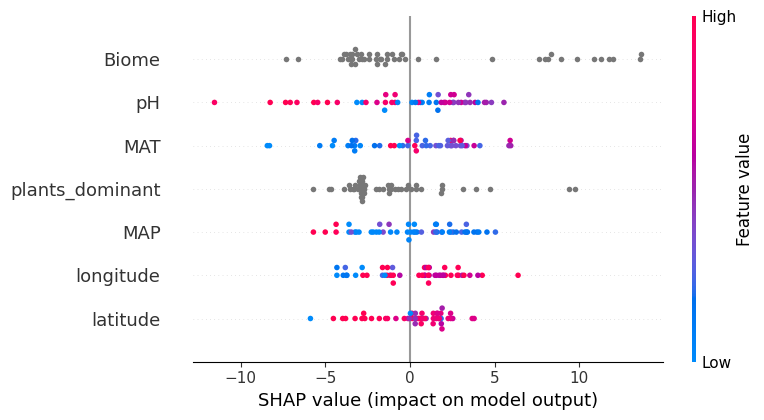

In [ ]:
# Aggregate SHAP values across all output classes using sum
aggregated_shap_values = shap_values.sum(axis=2)

# Now, use the aggregated SHAP values in the summary plot
shap.summary_plot(aggregated_shap_values, subsample)

In [ ]:
X_test.iloc[10]

,30
longitude,4.8941
latitude,50.8459
Biome,forest
MAT,10.4
MAP,721
pH,7.16
plants_dominant,Stachys sylvatica
target_gene,SSU


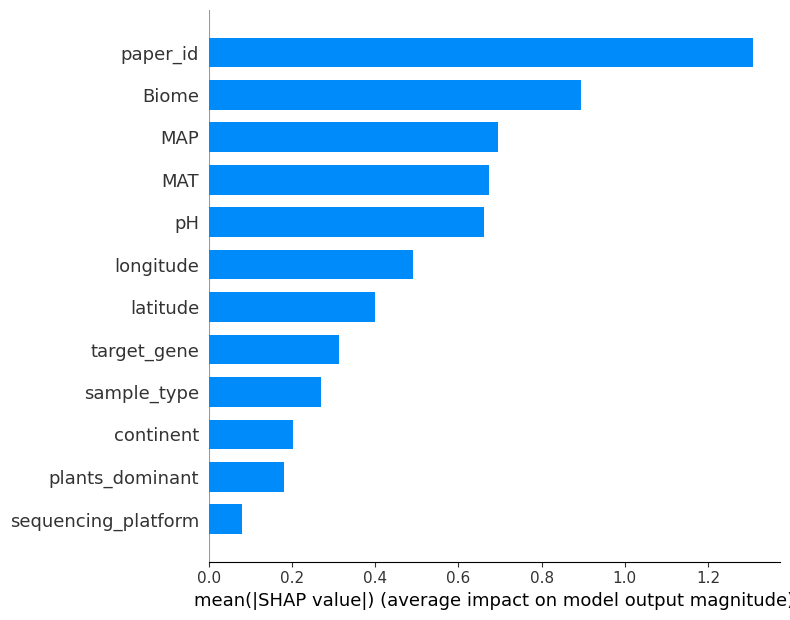

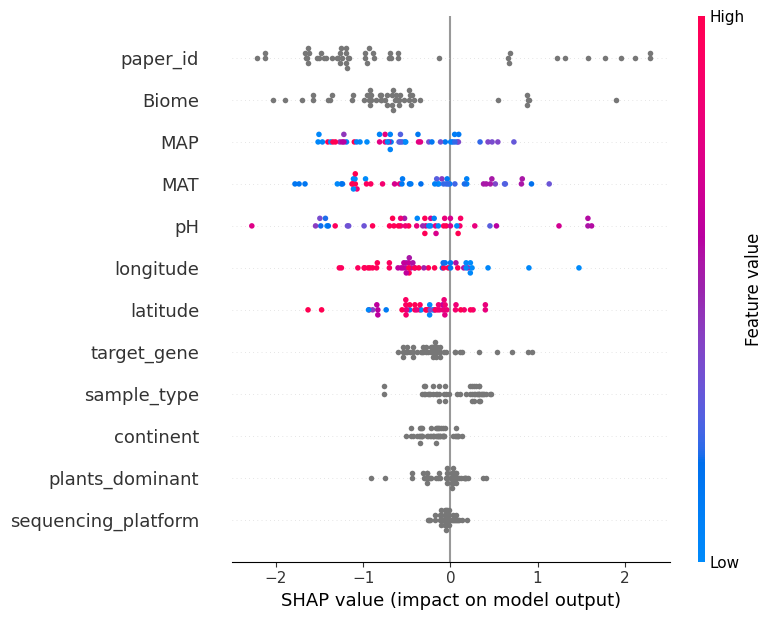

In [ ]:
explainer = shap.TreeExplainer(model)
random_indices = np.random.choice(X_train.shape[0], size=50, replace=False)
subsample = X_train.iloc[random_indices]
shap_values = explainer.shap_values(subsample)
shap.summary_plot(shap_values, subsample, plot_type="bar")
shap.summary_plot(shap_values, subsample)

## Classifier Chains

In [27]:
X_train = X_train.join(pd.get_dummies(X_train["Biome"], dtype="int")).drop(columns=["Biome"])
X_test = X_test.join(pd.get_dummies(X_test["Biome"], dtype="int")).drop(columns=["Biome"])

Use only numerical columns and optimize with optuna

### Base classifier: XGBoost

In [ ]:
def objective_classifier_chain(trial):

    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Initialize the base classifier
    base_classifier = xgb.XGBClassifier(
        **param,
        verbosity=0,
        objective="binary:logistic",
        #tree_method="hist",
        eval_metric="logloss"
        )

    # Initialize ClassifierChain
    chain = ClassifierChain(base_classifier, order='random', random_state=42)

    # Fit ClassifierChain
    chain.fit(Xnum_train, yn_train)

    # Predict on validation data
    y_pred = chain.predict(Xnum_test)

    # Calculate F1 score (micro or macro depending on your dataset)
    f1 = f1_score(yn_test, y_pred, average="micro")
    return f1

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective_classifier_chain, n_trials=100, timeout=600)


In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.8341708542713567
  Params: 
    booster: gbtree
    lambda: 3.12809893289736e-08
    alpha: 9.00307896097447e-07
    subsample: 0.9360551753389746
    colsample_bytree: 0.9719568101943314
    max_depth: 5
    min_child_weight: 2
    eta: 0.23879203729468418
    gamma: 0.0003608286477786637
    grow_policy: lossguide


In [ ]:
base_classifier = xgb.XGBClassifier(**best_trial.params)
chain_model = ClassifierChain(base_classifier, order='random', random_state=42)
chain_model.fit(Xnum_train, y_train)
preds = chain_model.predict(Xnum_test)

In [ ]:
macro_f1 = f1_score(y_test, preds, average="macro")
micro_f1 = f1_score(y_test, preds, average="micro")
hl = hamming_loss(y_test, preds)
acc = accuracy_score(y_test, preds)

print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")

Macro F1 Score: 0.666
Micro F1 Score: 0.720
Hamming loss: 0.063
Accuracy score: 0.367


In [ ]:
k=3
macro_f1 = f1_score(y_test.values[:, :k], preds[:, :k], average="macro")
micro_f1 = f1_score(y_test.values[:, :k], preds[:, :k], average="micro")
hl = hamming_loss(y_test.values[:, :k], preds[:, :k], )
acc = accuracy_score(y_test.values[:, :k], preds[:, :k], )

print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")

Macro F1 Score: 0.785
Micro F1 Score: 0.813
Hamming loss: 0.107
Accuracy score: 0.710


### Base classifier: Catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X_train.columns

Index(['longitude', 'latitude', 'Biome', 'MAT', 'MAP', 'pH',
       'plants_dominant'],
      dtype='object')

In [ ]:
# Objective function for Optuna
def objective_catboost_chain(trial):
    # Define CatBoost parameters
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
          }

    # Initialize the base CatBoost classifier
    base_classifier = CatBoostClassifier(**param, verbose=0, cat_features=[0, 3, 4, 5, 6, 7, 8])

    # Initialize ClassifierChain
    chain = ClassifierChain(base_classifier, order='random', random_state=42)

    # Fit ClassifierChain
    chain.fit(X_train, y_train)

    # Predict on validation data
    y_pred = chain.predict(X_test)

    # Calculate F1 score (micro or macro depending on your dataset)
    f1 = f1_score(y_test, y_pred, average="micro")
    return f1

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost_chain, n_trials=50, timeout=600)

# Print best hyperparameters
print("Best parameters:", study.best_params)


Best parameters: {'iterations': 1000, 'learning_rate': 0.004861937429076506, 'depth': 9, 'l2_leaf_reg': 1.3371767884862262, 'random_strength': 0.12370991371482613, 'bagging_temperature': 0.6322665978513103, 'border_count': 195}


In [56]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.7804878048780488
  Params: 
    n_estimators: 66
    max_depth: 19
    min_samples_split: 4
    min_samples_leaf: 1


In [ ]:
base_classifier = CatBoostClassifier(**best_trial.params, verbose=0, cat_features=[0, 3, 4, 5, 6, 7, 8])
chain = ClassifierChain(base_classifier, order='random', random_state=42)
chain.fit(X_train, y_train)
preds = chain.predict(X_test)

In [ ]:
#Y_test = Y.iloc[y_val.index, :3]

macro_f1 = f1_score(y_test, preds, average="macro")
micro_f1 = f1_score(y_test, preds, average="micro")
hl = hamming_loss(y_test, preds)
acc = accuracy_score(y_test, preds)

print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


Macro F1 Score: 0.720
Micro F1 Score: 0.766
Hamming loss: 0.055
Accuracy score: 0.430


### Base classifier: Random Forest

In [38]:
def objective_rf(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)

    # Base classifier
    base_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    chain = ClassifierChain(base_classifier)

    chain.fit(X_train, y_train)

    y_pred = chain.predict(X_test)

    f1 = f1_score(y_test, y_pred, average="micro")
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=50, timeout=600)

In [39]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.7633928571428571
  Params: 
    n_estimators: 97
    max_depth: 18
    min_samples_split: 9
    min_samples_leaf: 1


In [40]:
base_classifier = RandomForestClassifier(**best_trial.params, random_state=42)
chain = ClassifierChain(base_classifier)
chain.fit(X_train, y_train)
preds = chain.predict(X_test)

In [41]:
k=10
preds2 = preds[:, :k]
y_testv = y_test[:, :k]

#f1 = f1_score(y_testv, preds2, average="binary")
macro_f1 = f1_score(y_testv, preds2, average="macro")
micro_f1 = f1_score(y_testv, preds2, average="micro")
hl = hamming_loss(y_testv, preds2)
acc = accuracy_score(y_testv, preds2)


print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


Macro F1 Score: 0.756
Micro F1 Score: 0.763
Hamming loss: 0.081
Accuracy score: 0.490


### Base classifier: Support Vector Machine

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def objective_svm(trial):

    params = {
        "C": trial.suggest_float("C", 1e-3, 1e2),
        "kernel": trial.suggest_categorical("kernel", ["rbf"]),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }

    base_classifier = SVC(
          **params,
          #probability=True,
          random_state=42)

    chain = ClassifierChain(base_classifier)

    chain.fit(X_train, y_train)

    y_pred = chain.predict(X_test)

    f1 = f1_score(y_test, y_pred, average="micro")
    return f1

    # Evaluate using cross-validation

study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters for SVM:", study_svm.best_params)

Best hyperparameters for SVM: {'C': 80.2425090474954, 'kernel': 'rbf', 'gamma': 'auto'}


In [33]:
print("Best trial:")
best_trial = study_svm.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6931407942238267
  Params: 
    C: 80.2425090474954
    kernel: rbf
    gamma: auto


In [34]:
base_classifier = SVC(**best_trial.params, random_state=42)
chain = ClassifierChain(base_classifier)
chain.fit(X_train, y_train)
preds = chain.predict(X_test)

In [35]:
k=10
preds2 = preds[:, :k]
y_testv = y_test[:, :k]

#f1 = f1_score(y_testv, preds2, average="binary")
macro_f1 = f1_score(y_testv, preds2, average="macro")
micro_f1 = f1_score(y_testv, preds2, average="micro")
hl = hamming_loss(y_testv, preds2)
acc = accuracy_score(y_testv, preds2)


print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Micro F1 Score: {micro_f1:.3f}")
print(f"Hamming loss: {hl:.3f}")
print(f"Accuracy score: {acc:.3f}")


Macro F1 Score: 0.699
Micro F1 Score: 0.693
Hamming loss: 0.098
Accuracy score: 0.433


# some distance handling

In [ ]:
!pip install haversine

In [ ]:
from haversine import haversine, Unit
from scipy.spatial.distance import pdist, squareform

# Prepare coordinates as tuples (latitude, longitude)
coords = df3[['latitude', 'longitude']].to_numpy()
# Compute pairwise distances using haversine
distance_matrix = pdist(coords, metric=lambda u, v: haversine(u, v, unit=Unit.METERS))

In [ ]:
linkage_matrix = linkage(distance_matrix, method='complete')

In [ ]:
cluster_labels = fcluster(linkage_matrix, t=100, criterion='distance')


In [ ]:
df3.groupby(cluster_labels)

In [ ]:

# Convert to a DataFrame for easy handling
distance_df = pd.DataFrame(distance_matrix, columns=df3.index, index=df3.index)

print(distance_df)

In [ ]:
grouped = df3.groupby(["paper_id", "primers", "continent", "sample_type", "Biome", "year_of_sampling", "plants_dominant", "target_gene", "sequencing_platform"])

In [ ]:
groups_count = grouped.size()
groups_count.name = "size"

In [ ]:
groups_count = groups_count.reset_index()


In [ ]:
groups_count.sort_values("size", ascending=False)

,paper_id,primers,continent,sample_type,Biome,year_of_sampling,plants_dominant,target_gene,sequencing_platform,size
272,Rincon_2021_1GU,AML1/AML2 then NS31/AM1,Africa,soil,cropland,2012,Theobroma cacao,SSU,Illumina,47
371,Xiang_2014_BD5B,AML1/AML2 then NS31/AM1,Asia,soil,cropland,2010,Zea mays,SSU,454Roche,46
196,Fan_2020_1GN,AMV4.5NF/AMDGR,Asia,rhizosphere soil,cropland,2015,Triticum aestivum,SSU,Illumina,45
197,Fan_2020_1GN,AMV4.5NF/AMDGR,Asia,soil,cropland,2015,Triticum aestivum,SSU,Illumina,45
285,Sandoz_2020_1CV,AMV4.5NF/AMDGR,Europe,root,grassland,2015,Botrychium lunaria,SSU,Illumina,40
...,...,...,...,...,...,...,...,...,...,...
184,Davison_2018_1AQ,NS31/AML2,Europe,root,tundra,2011,Geranium sylvaticum,SSU,454Roche,1
185,Davison_2018_1AQ,NS31/AML2,Europe,root,tundra,2011,Rubus saxatilis,SSU,454Roche,1
186,Davison_2018_1AQ,NS31/AML2,Europe,root,woodland,2009,Helichrysum stoechas,SSU,454Roche,1
187,Davison_2018_1AQ,NS31/AML2,Europe,root,woodland,2009,Pallenis spinosa,SSU,454Roche,1


In [ ]:
by_plant = df3.groupby(["plants_dominant", "paper_id"]).size()
by_plant.name = "size"

In [ ]:
by_plant = by_plant.reset_index()
by_plant.sort_values("size", ascending=False)

,plants_dominant,paper_id,size
330,Triticum aestivum,Fan_2020_1GN,90
233,Plantago lanceolata,Rasmussen_2018_C8E6,59
133,Eragostis tef,Ezeokoli_2020_1AW,52
319,Theobroma cacao,Rincon_2021_1GU,47
347,Zea mays,Xiang_2014_BD5B,46
...,...,...,...
149,Galium boreale;Erigeron caespitosus;Danthonia ...,Stover_2018_1DI,1
151,Geranium erianthum,Davison_2015_1GM,1
153,Geranium sessiliflorum,Davison_2015_1GM,1
154,Geranium sylvaticum,Davison_2015_1GM,1


In [ ]:
presence_absence = df3.groupby(["y", "continent"]).size().unstack()

continent
Europe           1497
Asia              617
North America     522
Africa            278
South America      94
Australia          78
Name: count, dtype: int64

# Multi-predictor class

In [ ]:
!pip install --upgrade autogluon.tabular

In [35]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str]
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str]
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = self.eval_metrics[label]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict
